In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage import transform
import skimage.io as io
from skimage.color import rgb2gray, rgba2rgb, gray2rgb
import scipy.interpolate as interpolate
import seaborn as sns
from matplotlib import cm
from skimage.morphology import dilation, square
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib qt
%matplotlib inline


In [2]:
def get_non_zero_pixels(img: np.ndarray) -> np.ndarray:
    """
    Returns the indices of non-zero pixels in a grayscale image.

    Parameters:
        img (np.ndarray): A 2D array representing a grayscale image.

    Returns:
        np.ndarray: An array containing row and column indices of non-zero pixels.
    """
    return np.stack(np.where(img > 0), axis=1)

In [3]:
def gray_to_binary(img: np.ndarray, threshold: int) -> np.ndarray:
    """
    Converts a grayscale image to a black and white binary image.

    Parameters:
        img (np.ndarray): A 2D array representing a grayscale image.
        threshold (int): Intensity value; pixels greater than this threshold become white (1), 
                     others black (0).

    Returns:
        np.ndarray: Binary image with pixels converted to black (0) or white (1).
    """
    return np.where(img > threshold, 1, 0)


In [7]:
img = rgb2gray(rgba2rgb(io.imread("../images/lane.png"))) * 255

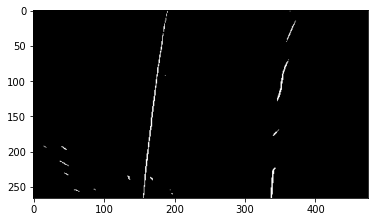

In [8]:
plt.imshow(gray_to_binary(img, 200), cmap='gray');

### Lane Detection with Hough Transform

#### Hough Transform Steps
1. **Initialization:** Create an empty 2D accumulator array covering theta values from 0 to 180 and a range of r calculated from image dimensions.
2. **Pixel Coordinates:** Identify coordinates (x, y) of white pixels in the image (likely after edge detection).
3. **Voting Process:** Loop through each pixel and iterate over possible theta values, calculating corresponding r values.
4. **Accumulator Update:** Increment the cell in the 2D array representing r by one for each pixel.
5. **Peak Identification:** Identify the theta and r pair with the highest peak in the accumulator array.
6. **Peak Refinement:** Create a window around the highest peak and eliminate its neighboring peaks.
7. **Secondary Peak:** Identify the second peak after refining the accumulator array.
8. **Conversion:** Convert the refined peaks back to Cartesian space for lane line extraction.


In [9]:
def calc_r_vec(thetas: np.ndarray, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Calculates r values in polar coordinates for multiple x, y, and thetas using the equation:
    r = x * np.cos(theta) + y * np.sin(theta).
    
    Parameters:
        thetas (np.ndarray): Array of thetas in degrees.
        x (np.ndarray): Array of x values.
        y (np.ndarray): Array of y values.
    
    Returns:
        np.ndarray: Array of polar coordinates r values.
    """
    theta_rad = np.deg2rad(thetas)
    cos_theta = np.cos(theta_rad)
    sin_theta = np.sin(theta_rad)
    r = np.outer(x, cos_theta) + np.outer(y, sin_theta)
    return r.astype(int)

In [10]:
# used in drawing the lines
def polar_to_cartesian_y(x: np.ndarray, r: int, theta: int) -> np.ndarray:
    """
    Calculates Cartesian y values given x and (r, theta) of the polar coordinates.
    
    Parameters:
        x (np.ndarray): Array of x values.
        r (int): Value of r.
        theta (int): Value of theta in degrees.
        
    Returns:
        np.ndarray: Calculated Cartesian y values.
    """
    theta_rad = np.deg2rad(theta)
    sin_theta = np.sin(theta_rad)
    cos_theta = np.cos(theta_rad)
    
    y = (r - x * cos_theta) / (sin_theta + 1e-9)
    return y.astype(int)


In [11]:
# NOT USED
def max_filter(arr: np.ndarray, kernel_size: int) -> np.ndarray:
    """
    Applies a max filter on a 2D array using a sliding window and retains only the maximum value.
    
    Parameters:
        arr (np.ndarray): Input 2D array.
        kernel_size (int): Size of the square kernel for the sliding window.
    
    Returns:
        np.ndarray: Filtered array containing only the maximum values within the sliding window.
    """
    data = np.zeros(arr.shape)
    height, width = arr.shape
    offset = int(kernel_size / 2)
    
    for j in range(offset, height - offset, kernel_size):
        for i in range(offset, width - offset, kernel_size):
            window = arr[j - offset : j + offset + 1, i - offset : i + offset + 1]
            idx = np.argmax(window)
            idx = np.unravel_index(idx, window.shape)
            data[j + idx[0] - offset, i + idx[1] - offset] = window[idx]
    
    return data


In [12]:
def remove_neighbors(data: np.ndarray, theta: int, r: int, kernel_size: int) -> np.ndarray:
    """
    Nullifies value at (theta, r) and its neighbors within a specified kernel size.
    
    Parameters:
        data (np.ndarray): A 2D array where thetas are rows and columns are r.
        theta (int): Index along the theta dimension.
        r (int): Index along the r dimension.
        kernel_size (int): Size of the kernel.
    
    Returns:
        np.ndarray: Filtered array.
    """
    half_kernel = kernel_size // 2

    start_th = np.clip(theta - half_kernel, 0, data.shape[0])
    end_th = np.clip(theta + half_kernel + 1, 0, data.shape[0])

    start_r = np.clip(r - half_kernel, 0, data.shape[1])
    end_r = np.clip(r + half_kernel + 1, 0, data.shape[1])

    data[start_th:end_th, start_r:end_r] = 0
    return data

In [13]:
def get_max_value_idx(data: np.ndarray) -> np.ndarray:
    """
    Finds the indices of the maximum value in a 2D array.

    Parameters:
    - data (np.ndarray): Input 2D array.

    Returns:
    - np.ndarray: Indices of the maximum value in the input array.
    """
    sorted_arr = np.sort(data.reshape(-1))
    return np.argwhere(data == sorted_arr[-1])[0]

In [14]:
def hough_transform(img, thetas_step=4, kernel_size=35, return_arr=False):
    """
    Performs Hough Transform on an image to detect peaks and return their polar coordinates.

    Parameters:
    - img (np.ndarray): Input image.
    - thetas_step (int): Step size for theta values.
    - kernel_size (int): Size of the kernel for neighbor removal.
    - return_arr (bool): Flag to return arrays if True.

    Returns:
    - Tuple or individual values:
        (r1, theta1, r2, theta2, h_arr, new_h_arr) if return_arr is True.
        r1, theta1, r2, theta2 otherwise.
    """
    # Calculate image dimensions
    h, w = img.shape
    D = int(np.sqrt(h**2 + w**2))
    
    # Create Hough array
    h_arr = np.zeros((180, 2*D))

    # Get coordinates of non-zero pixels
    non_zero_pxls = get_non_zero_pixels(img)
    
    # Calculate r
    thetas = range(0, 180, thetas_step)
    x = non_zero_pxls[:, 0]
    y = non_zero_pxls[:, 1]
    r = calc_r_vec(thetas, x, y) + D
    np.add.at(h_arr, (thetas, r), 1)  # Update h_arr
    
    new_h_arr = h_arr.copy()
    
    # Get first peak
    theta1, r1 = get_max_value_idx(new_h_arr)
    
    # Remove max peak neighbors
    new_h_arr = remove_neighbors(new_h_arr, theta1, r1, kernel_size)
    
    # Get second peak
    theta2, r2 = get_max_value_idx(new_h_arr)
    r1 -= D
    r2 -= D
    
    # Return values based on flag
    if return_arr:
        return r1, theta1, r2, theta2, h_arr, new_h_arr
    return r1, theta1, r2, theta2


In [15]:
%time r1, theta1, r2, theta2, h_arr, data = hough_transform(img, return_arr=True)

Wall time: 23.9 ms


In [16]:
def plot_3d(data: np.ndarray, ax: Axes3D):
    """
    Plots a 3D surface given input data and axis.

    Parameters:
    - data (np.ndarray): Input data for the surface plot.
    - ax (plt.Axes3D): Matplotlib 3D axis object for the plot.
    """
    x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    surf = ax.plot_surface(x, y, data, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

In [29]:
# Needs Optimization
def draw_line(img: np.ndarray, r: int, theta: int) -> np.ndarray:
    """
    Draws a line on an image given polar coordinates.

    Parameters:
    - img (np.ndarray): Input image.
    - r (int): Polar coordinate r.
    - theta (int): Polar coordinate theta.

    Returns:
    - np.ndarray: Image with drawn line.
    """
    height, width, c = img.shape
    mask = np.zeros(img.shape)
    x = np.array(range(height))
    y = polar_to_cartesian_y(x, r, theta)
    
    # find indices where 0 < y < width
    indices = np.where(np.logical_and(y > 0, y < width))[0]
    
    # filter x, y
    filtered_x = x[indices]
    filtered_y = y[indices]
    
    mask[filtered_x, filtered_y] = [0, 254, 0]  # Set pixel color (green) on the line
    mask[:, :, 1] = dilation(mask[:, :, 1], square(5))
    return np.maximum(img, mask)


In [30]:
def pipeline(img):
    """
    Applies the Hough transform process on the input image to detect road lines.
    It generates lines using Hough transform, draws them on the image, and plots the peaks 
    of the Hough array before and after removing the first peak.

    Parameters:
    - img (np.ndarray): Input image.

    Returns:
    None
    """
    r1, theta1, r2, theta2, hough_array, new_hough_array = hough_transform(img, return_arr=True)
    line_image = np.zeros((img.shape[0], img.shape[1], 3))
    line_image = draw_line(gray2rgb(img), r1, theta1)
    line_image = draw_line(line_image, r2, theta2)
    line_image = line_image / np.max(line_image)
    
    # Visualization
    fig = plt.figure(figsize=(12, 5))

    # Image with drawn lines
    ax1 = fig.add_subplot(131)
    ax1.imshow(line_image)
    ax1.set_title('Detected Lines')

    # Plotting the peaks of the Hough array before removing the first peak
    ax2 = fig.add_subplot(132, projection='3d')
    plot_3d(hough_array, ax2)
    ax2.set_title('Hough Peaks (Before)')

    # Plotting the peaks of the Hough array after removing the first peak
    ax3 = fig.add_subplot(133, projection='3d')
    plot_3d(new_hough_array, ax3)
    ax3.set_title('Hough Peaks (After Removal)')

    # Set the same z-axis limits and ticks for both 3D plots
    z_min = np.min(hough_array)
    z_max = np.max(hough_array)
    ax2.set_zlim(z_min, z_max)
    ax3.set_zlim(z_min, z_max)
    
    plt.tight_layout()
    plt.show()

In [31]:
# make different rotations of "img" and apply the test the algorithm
dataset = []
for i in range(0, 360, 20):
    dataset.append(transform.rotate(img, i))

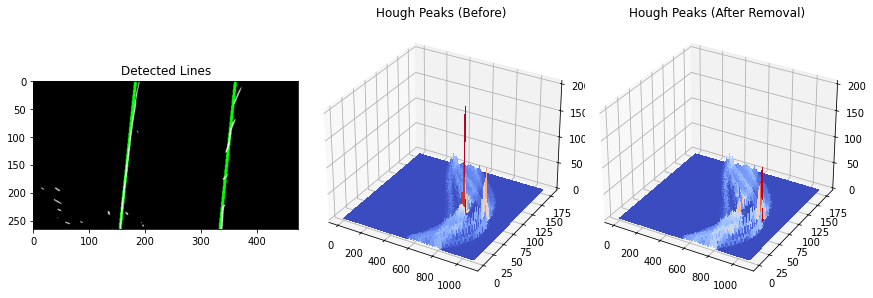

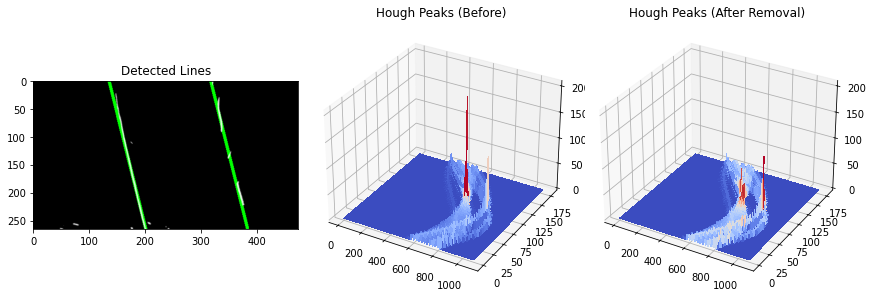

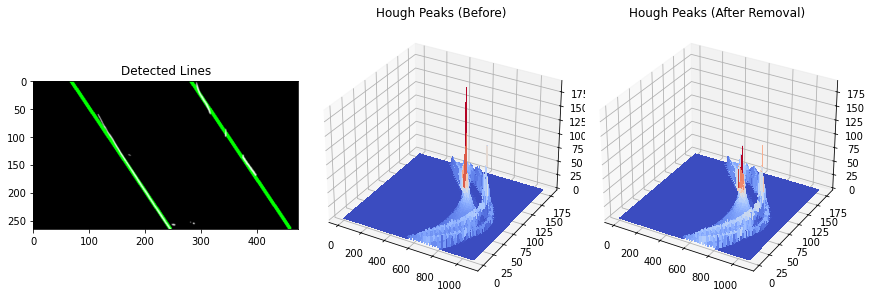

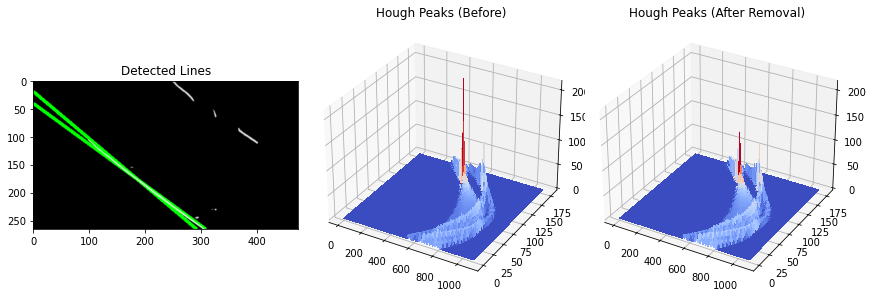

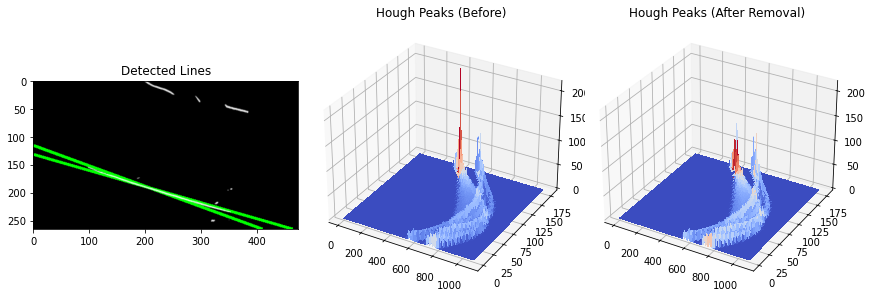

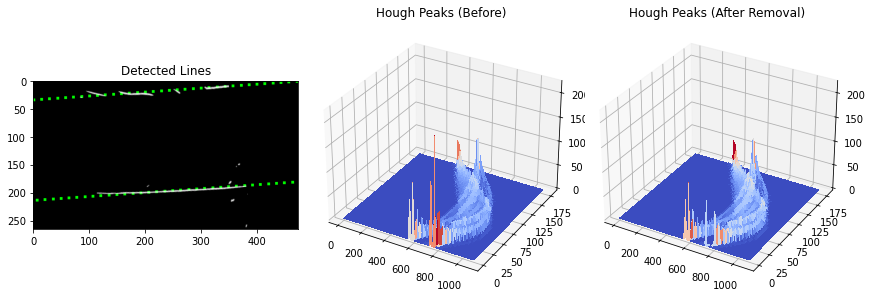

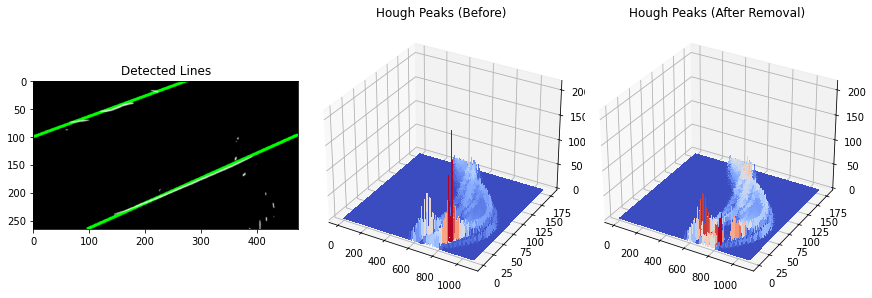

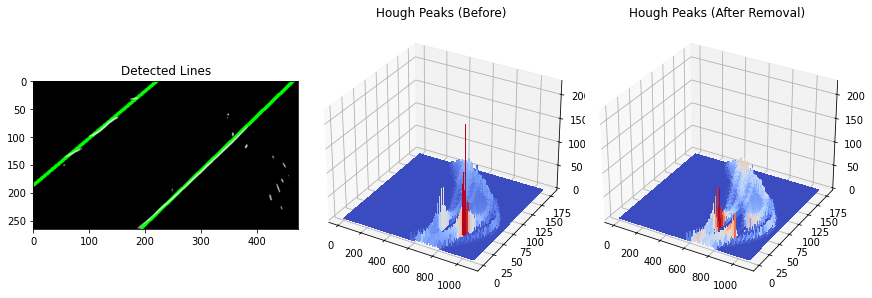

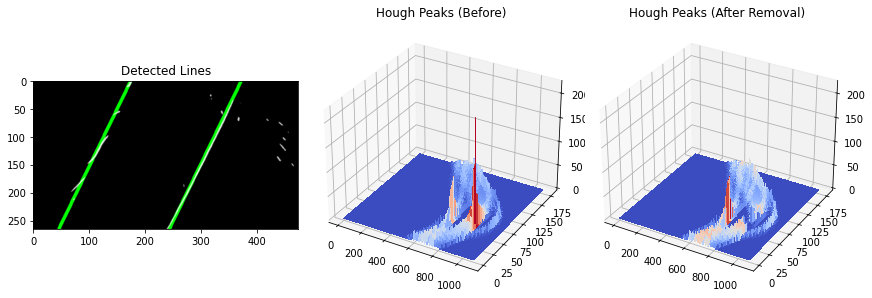

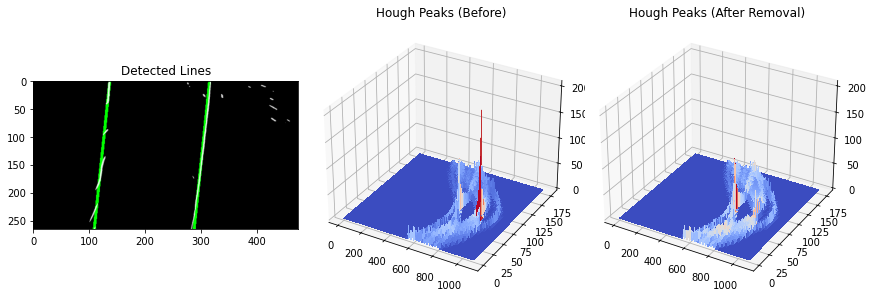

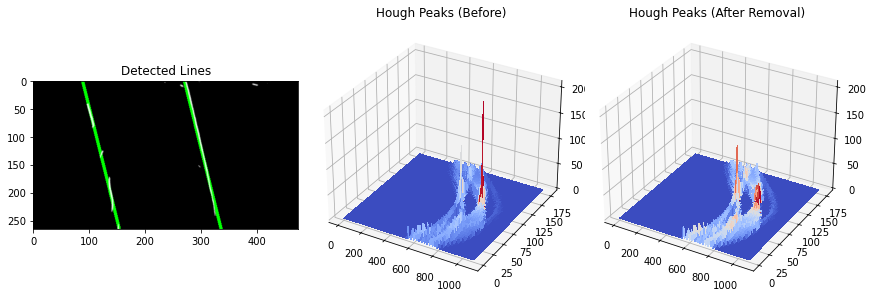

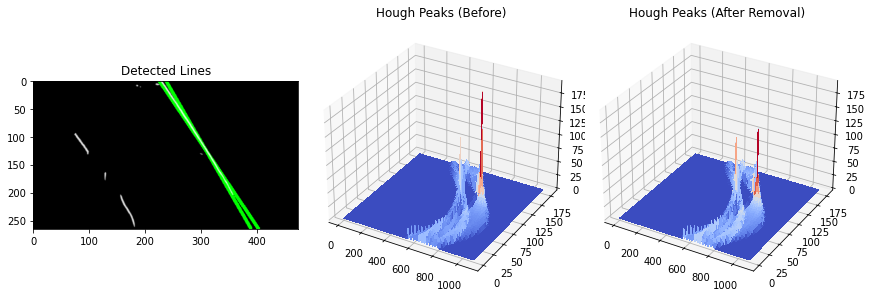

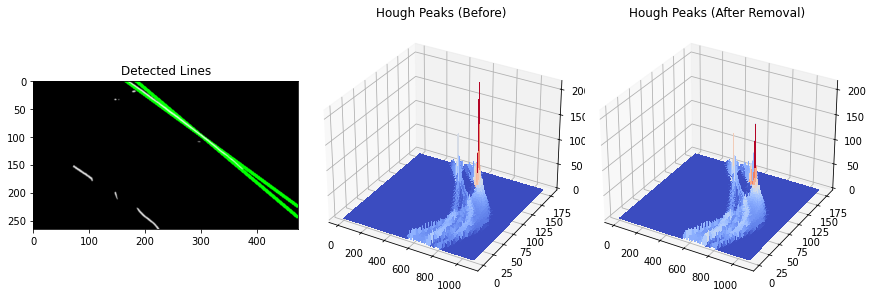

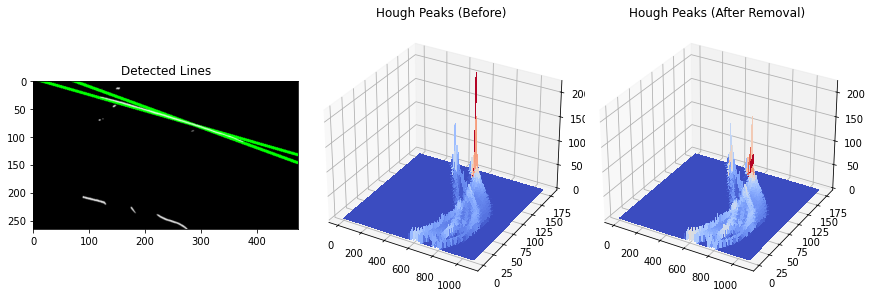

C:\Users\Ali\AppData\Local\Temp/ipykernel_14704/1311184152.py:19: RuntimeWarning: invalid value encountered in cast
  return y.astype(int)


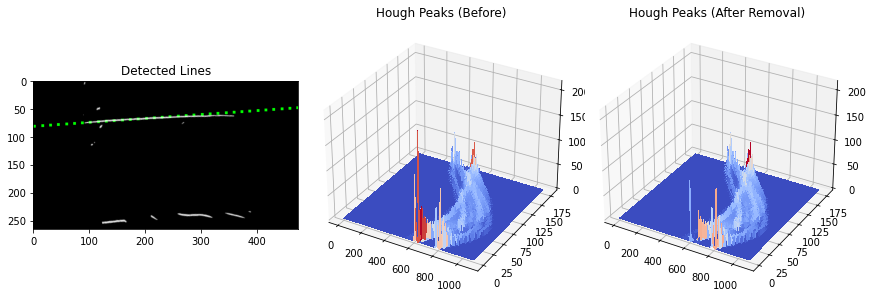

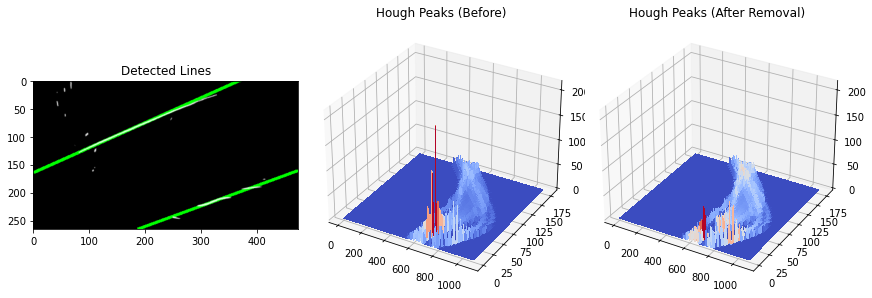

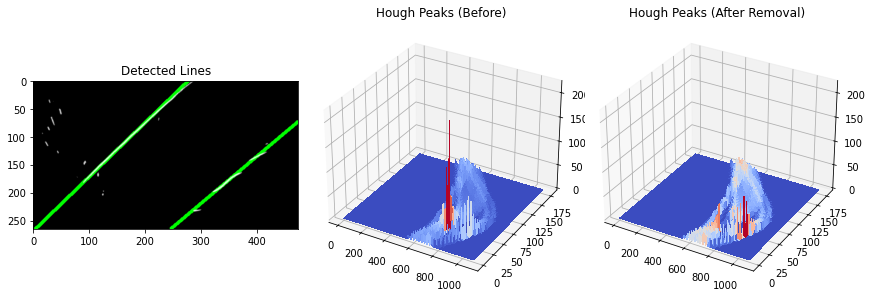

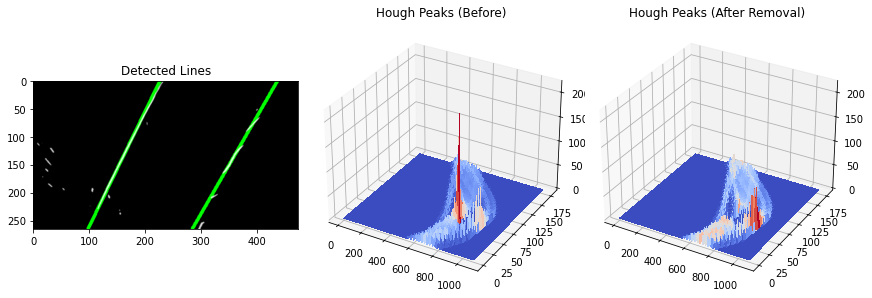

In [32]:
for img_ in dataset:
    pipeline(img_);

# **End!**